# Model selection using lmfit and emcee 

`lmfit.emcee` can be used to obtain the posterior probability distribution of parameters, given a set of experimental data. This notebook shows how it can be used for Bayesian model selection.

In [1]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [2]:
# calculate a Gaussian
def gauss(x, a_max, loc, sd):
    return a_max * np.exp(-((x - loc) / sd)**2)

In [3]:
# Generate some data
x = np.linspace(3, 7, 250)
np.random.seed(0)
y = 4 + 10 * x + gauss(x, 200, 5, 0.5) + gauss(x, 60, 5.8, 0.2)
dy = np.sqrt(y)
y += dy * np.random.randn(np.size(y))

<Container object of 3 artists>

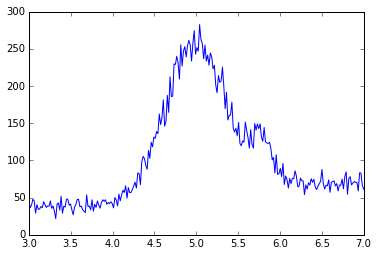

In [4]:
plt.errorbar(x, y)

In [5]:
# the normalised residual for the data
def residual(p, just_generative=False):
    v = p.valuesdict()
    generative = v['a'] + v['b'] * x
    M = 0
    while 'a_max%d' % M in v:
        generative += gauss(x, v['a_max%d'%M], v['loc%d'%M], v['sd%d'%M])
        M += 1

    if just_generative:
        return generative
    return (generative - y) / dy

In [6]:
# create a Parameter set for the initial guesses
def initial_peak_params(M):
    p = lmfit.Parameters()
    
    # a and b give a linear background
    a = np.mean(y)
    b = 1
    
    # a_max, loc and sd are the amplitude, location and SD of each gaussian component
    a_max = np.max(y)
    loc = np.mean(x)
    sd = (np.max(x) - np.min(x)) * 0.5

    p.add_many(('a', np.mean(y), True, 0, 10), ('b', b, True, 1, 15))

    for i in range(M):
        p.add_many(('a_max%d'%i, 0.5 * a_max, True, 10, a_max),
                   ('loc%d'%i, loc, True, np.min(x), np.max(x)),
                   ('sd%d'%i, sd, True, 0.1, np.max(x) - np.min(x)))
    return p

Solving with `minimize` gives the Maximum Likelihood solution.

In [7]:
p1 = initial_peak_params(1)
mi1 = lmfit.minimize(residual, p1, method='differential_evolution')

lmfit.printfuncs.report_fit(mi1.params, min_correl=0.5)

[[Variables]]
    a:        1.51236732 (init= 10)
    b:        10.5608914 (init= 1)
    a_max0:   193.129348 (init= 141.2683)
    loc0:     5.03878685 (init= 5)
    sd0:      0.57126003 (init= 2)
[[Correlations]] (unreported correlations are <  0.500)


From inspection of the data above we can tell that there is going to be more than 1 Gaussian component, but how many are there? A Bayesian approach can be used for this model selection problem. We can do this with `lmfit.emcee`, which uses the `emcee` package to do a Markov Chain Monte Carlo sampling of the posterior probability distribution. `lmfit.emcee` requires a function that returns the log-posterior probability. The log-posterior probability is a sum of the log-prior probability and log-likelihood functions. 

The log-prior probability encodes information about what you already believe about the system. `lmfit.emcee` assumes that this log-prior probability is zero if all the parameters are within their bounds and `-np.inf` if any of the parameters are outside their bounds. As such it's a uniform prior. 

The log-likelihood function is given below.

To use non-uniform priors then should include these terms in `lnprob`.

In [8]:
# This is the log-likelihood probability for the sampling.
def lnprob(p):
    resid = residual(p, just_generative=True)
    return -0.5 * np.sum(((resid - y) / dy)**2 + np.log(2 * np.pi * dy**2))

To start with we have to create the minimizers and *burn* them in. We create 4 different minimizers representing 0, 1, 2 or 3 Gaussian contributions. To do the model selection we have to integrate the over the log-posterior distribution to see which has the higher probability. This is done using the `thermodynamic_integration_log_evidence` method of the `sampler` attribute contained in the `lmfit.Minimizer` object.

In [9]:
# Work out the log-evidence for different numbers of peaks
total_steps = 310
burn = 300
thin = 10
ntemps = 15
workers=4
log_evidence = []
mini = []
res = []

# set up the Minimizers
for i in range(4):
    p0 = initial_peak_params(i)
    mini.append(lmfit.Minimizer(lnprob, p0))
    out = mini[i].minimize(method='differential_evolution')
    res.append(out)

# burn in the samplers
for i in range(4):
    # do the sampling
    out = mini[i].emcee(steps=total_steps, ntemps=ntemps, workers=workers, reuse_sampler=False,
                       params=res[i].params)
    # get the evidence
    print(i, total_steps, mini[i].sampler.thermodynamic_integration_log_evidence())
    log_evidence.append(mini[i].sampler.thermodynamic_integration_log_evidence()[0])

0 310 (-4394.1394141818528, 0.78699415494884306)
1 310 (-1038.5082602579189, 3.5440488907950112)
2 310 (-923.39096623751232, 5.0783786979153547)
3 310 (-923.6894069769952, 5.6418844327914712)


Once we've burned in the samplers we have to do a collection run. We thin out the MCMC chain to reduce autocorrelation between successive samples.

In [10]:
for j in range(6):
    total_steps += 100
    for i in range(4):
        # do the sampling
        res = mini[i].emcee(burn=burn, steps=100, thin=thin, ntemps=ntemps,
                         workers=workers, reuse_sampler=True)
        # get the evidence
        print(i, total_steps, mini[i].sampler.thermodynamic_integration_log_evidence())
        log_evidence.append(mini[i].sampler.thermodynamic_integration_log_evidence()[0])

0 410 (-4394.2785416442975, 0.83244601315891487)
1 410 (-1038.6450874311915, 3.5634191857072892)
2 410 (-923.45302756653928, 5.0966495848754221)
3 410 (-923.82736691825357, 5.6538341407954249)
0 510 (-4394.3487587435875, 0.85588467626166675)
1 510 (-1038.6934181814577, 3.5598495634503706)
2 510 (-923.53824600518396, 5.1203799324430292)
3 510 (-923.82578592837626, 5.6281725406512351)
0 610 (-4394.401228206887, 0.87176207214633905)
1 610 (-1038.7503716831113, 3.5601188237437782)
2 610 (-923.61139504744551, 5.1481129345677346)
3 610 (-923.77987084071901, 5.5961124574821497)
0 710 (-4394.4249700306227, 0.87627960796453408)
1 710 (-1038.7884107190625, 3.5548852825279482)
2 710 (-923.77476076212815, 5.2038245396746561)
3 710 (-923.83444327268512, 5.6099999289124298)
0 810 (-4394.4437133300844, 0.88390942394744343)
1 810 (-1038.8249727101168, 3.5588724286415072)
2 810 (-923.92607632064164, 5.248356094005203)
3 810 (-923.8713318333505, 5.6097200131257523)
0 910 (-4394.4482814566245, 0.88343021

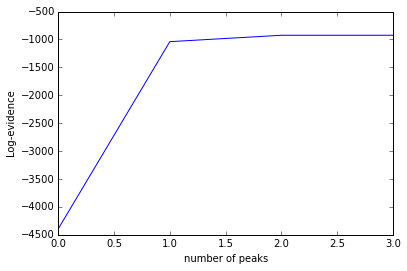

In [11]:
plt.plot(log_evidence[-4:])
plt.ylabel('Log-evidence')
plt.xlabel('number of peaks')

The Bayes factor is related to the exponential of the difference between the log-evidence values.  Thus, 0 peaks is not very likely compared to 1 peak. But 1 peak is not as good as 2 peaks. 3 peaks is not that much better than 2 peaks.

In [12]:
r01 = np.exp(log_evidence[-4] - log_evidence[-3])
r12 = np.exp(log_evidence[-3] - log_evidence[-2])
r23 = np.exp(log_evidence[-2] - log_evidence[-1])

In [13]:
print(r01, r12, r23)

0.0 1.43158716924e-50 0.909965654827


These numbers tell us that zero peaks is 0 times as likely as one peak. Two peaks is 7e49 times more likely than one peak. Three peaks is 1.1 times more likely than two peaks. With this data one would say that two peaks is sufficient. Caution has to be taken with these values. The log-priors for this sampling are uniform but improper, i.e. they are not normalised properly.  Internally the lnprior probability is calculated as 0 if all parameters are within their bounds and `-np.inf` if any parameter is outside the bounds. The `lnprob` function defined above is the log-likelihood alone. Remember, that the log-posterior probability is equal to the sum of the log-prior and log-likelihood probabilities. Extra terms can be added to the lnprob function to calculate the normalised log-probability.  These terms would look something like:

$\log \left(\prod_i \frac{1}{\max_i - \min_i}\right)$

where $\max_i$ and $\min_i$ are the upper and lower bounds for the parameter, and the prior is a uniform distribution. Other types of prior are possible. For example, you might expect the prior to be Gaussian.